## Setup

#### Imports

In [255]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
%matplotlib inline

#### Config

In [256]:
config = {
    
}

## Camera Calibration

In [257]:
images =  [mpimg.imread('camera_cal/' + file) for file in os.listdir('camera_cal')]
patternSize = (9,6)
objpoints = []
imgpoints = []
for image in images:
    gray = cv2.cvtColor(image ,cv2.COLOR_RGB2GRAY)
    retval, corners = cv2.findChessboardCorners(gray, patternSize)
    if retval:
        objpoints.append(np.float32([(x,y,0) for y in range(patternSize[1]) for x in range(patternSize[0])]))
        imgpoints.append(np.float32([corner[0] for corner in corners]))

ret, camera_matrix, distortion, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

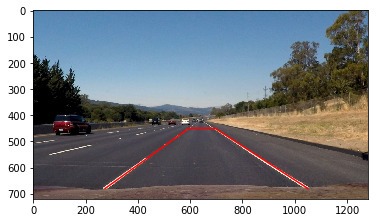

In [258]:
test_images = [mpimg.imread('test_images/' + filename) for filename in os.listdir('test_images')]
for image in test_images[2:]:
    plt.figure()
    plt.imshow(image)
    points = [[275, 680], [595, 450], [695, 450], [1050, 680]]
    x = [p[0] for p in points]
    y = [p[1] for p in points]
    plt.plot(x, y, color='red')
    break

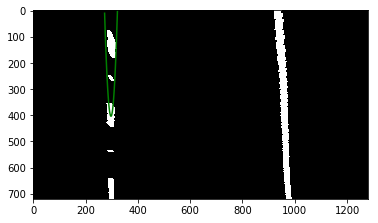

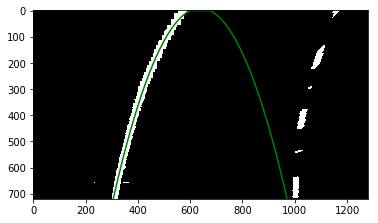

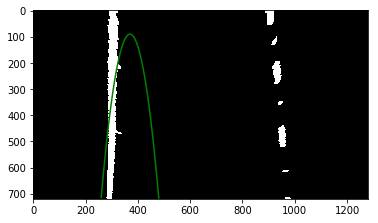

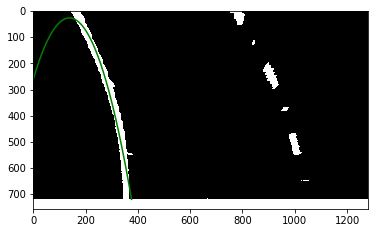

In [300]:
def warp_image(image):
    src = np.float32([[275, 680], [595, 450], [695, 450], [1050, 680]])
    dst = np.float32([[300, 720], [300, 0], [980, 0], [980, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, M, (1280, 720))
    return warped
    
def pipeline(image, camera_matrix, distortion_coeffs):
    image = cv2.undistort(image, camera_matrix, distortion_coeffs)
    
    red = image[:,:,0]
    green = image[:,:,1]
    blue = image[:,:,2]
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    hue = image[:,:,0]
    lightness = image[:,:,1]
    saturation = image[:,:,2]
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=15)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=15)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    sobel_mag = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel_mag = np.uint8(sobel_mag / np.max(sobel_mag) * 255)
    sobel_angle = np.arctan2(abs_sobely, abs_sobelx)
    
    x_index = np.int32([[x for x in range(gray.shape[1])] for y in range(gray.shape[0])])
    y_index = np.int32([[y for x in range(gray.shape[1])] for y in range(gray.shape[0])])
                       
    binary_output = np.zeros_like(gray)
    saturation_straddle = (saturation < 80) | (saturation > 200)
    grey_thresh = (gray > 100)
    lightness_thresh = (lightness > 150)
    hue_thresh = (hue > 150)
    x_index_thresh = (x_index > 0)
    y_index_thresh = (y_index > 300)
    scaled_sobel_mag_thresh = (scaled_sobel_mag > 50)
    sobel_angle_thresh = (sobel_angle > 0.7) & (sobel_angle < 1.3)
    
    binary = np.zeros_like(gray)
    search = (hue > 150) # start simple
    binary[search] = 1

    warped = warp_image(binary)
    if np.count_nonzero(warped) < 720 * 1280 // 5:
        return warped
    else:
        binary = np.zeros_like(gray)
#         search = (binary == 1) & (red > 130) & (green > 130) & (blue < 100) # for yellow line
        search = (hue > 200)
        binary[search] = 1
        return warp_image(binary)

def polyfit(binary):
    plt.figure()
    plt.imshow(binary, cmap='gray')
    
    colsums = np.sum(binary, axis=0)
    midpoint = binary.shape[1] // 2
    left_current = np.argmax(colsums[0:midpoint])
    right_current = np.argmax(colsums[midpoint:]) + midpoint
    
    nwindows = 10
    window_height = binary.shape[0] // nwindows
    left_points = []
    right_points = []
    for n in range(nwindows, 0, -1):
        bottom = window_height * n
        top = window_height * (n-1)
        left_box = binary[top:bottom, left_current-100: left_current+100]
        right_box = binary[top:bottom, right_current-100: right_current + 100]
        lefts = np.transpose(np.nonzero(left_box)) + [top, left_current-100]
        rights = np.transpose(np.nonzero(right_box)) + [top, right_current-100]
        left_points.append(lefts)
        right_points.append(rights)
        if len(lefts) > 0:
            left_current = int(np.mean(lefts[:,1]))
        if len(rights) > 0:
            right_current = int(np.mean(rights[:,1]))
    left_points = np.concatenate(left_points)
    right_points = np.concatenate(right_points)
    left_poly = np.polyfit(left_points[:,1], left_points[:,0], 2)
    right_poly = np.polyfit(right_points[:,1], right_points[:,0],2)
    left_calc = np.poly1d(left_poly)
    curve = [(x, left_calc(x)) for x in range(np.min(left)) if left_calc(x) < 720 and left_calc(x) > 0]
    x = [x for x,y in curve]
    y = [y for x,y in curve]
    plt.plot(x,y, 'g')
    
    
    
    
test_images = [mpimg.imread('test_images/' + filename) for filename in os.listdir('test_images')]
for i, image in enumerate(test_images):
    hard = (0,1,6,7)
    easy = (2,3,4,5)
    if i in easy:
        binary = pipeline(image, camera_matrix, distortion)
        poly = polyfit(binary)